# Networks of organisations


  
* Pajek book chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [76]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [77]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [78]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [79]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/francesco/kDrive/python_notebooks/astronomers/notebooks_jupyter/wikidata_exploration/../network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisation as original information.

...  [compléter]


In [80]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [81]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


## Inspect the data


In [ ]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  78224


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public research univer...
11,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,education,http://www.wikidata.org/entity/Q219563,University of Washington,1,public university
12,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,education,http://www.wikidata.org/entity/Q153265,University of Cincinnati,3,public university | research university | publ...


### Distribution of relationships in relation to birthYears of organisations members

In [ ]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

In [ ]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [ ]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,public university | comprehensive university |...,1921-1940
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1851-1900
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public research univer...,1921-1940


In [ ]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1751-1800     2030
1801-1850     4127
1851-1900    10668
1901-1920    10585
1921-1940    18688
1941-1960    19368
1961-1980    10344
1981-2000     2414
dtype: int64


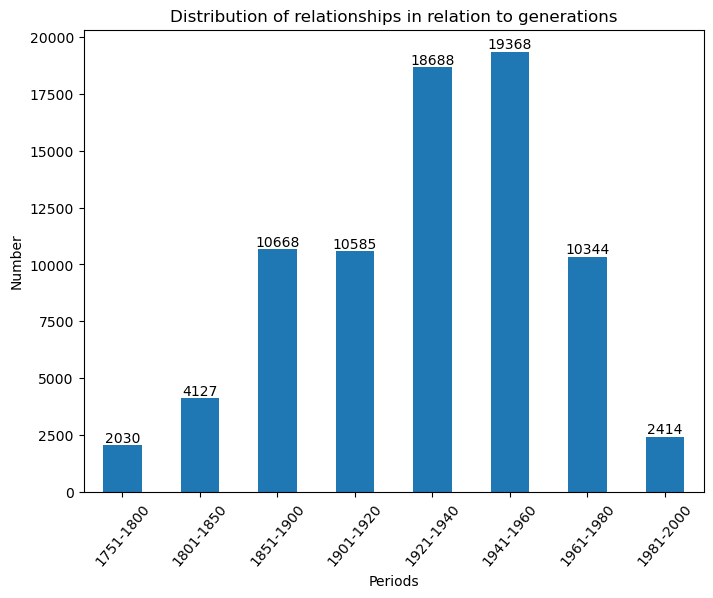

In [ ]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [ ]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


In [ ]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1751-1800   education   464
1   1751-1800  employment   460
2   1751-1800  membership  1106
3   1801-1850   education  1230
4   1801-1850  employment  1115
5   1801-1850  membership  1782
6   1851-1900   education  3908
7   1851-1900  employment  3826
8   1851-1900  membership  2934
9   1901-1920   education  4018
10  1901-1920  employment  4176
11  1901-1920  membership  2391
12  1921-1940   education  7231
13  1921-1940  employment  7300
14  1921-1940  membership  4157
15  1941-1960   education  7420
16  1941-1960  employment  8377
17  1941-1960  membership  3571
18  1961-1980   education  4054
19  1961-1980  employment  5019
20  1961-1980  membership  1271
21  1981-2000   education   969
22  1981-2000  employment  1264
23  1981-2000  membership   181


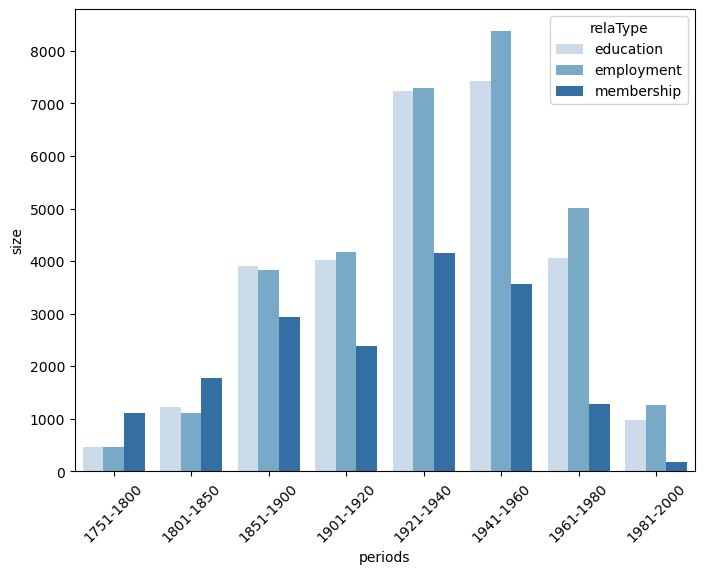

In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [ ]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


78224
[['academy of sciences', 'building'],
 ['comprehensive university',
  'open-access publisher',
  'organization',
  'public research university',
  'public university',
  'university of excellence'],
 ['academy of sciences', 'learned society', 'national academy']]


In [ ]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,comprehensive university | open-access publish...,1921-1940,"[comprehensive university, open-access publish..."
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1851-1900,[academy of sciences]
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public educational ins...,1921-1940,"[land-grant university, public educational ins..."


#### Organisations' types distribution

In [ ]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
university                                                                                                     2960
public university                                                                                              2420
academy of sciences                                                                                            1583
research institute                                                                                             1527
international organization | scientific organization                                                           1455
open-access publisher | public university                                                                      1432
open-access publisher | university                                                                             1401
academic publisher | learned society | nonprofit organization                                                  1321
academic publisher | academy of sciences | production company |

#### Save dataframe to CSV

In [ ]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

#### Reload from CSV

In [ ]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

## Types of organisations

Property **wdt:P31 instance of**

We try to figure out if we can use these types to sort out and distinguish the organisations

In [ ]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,university,2960,1
1,public university,2420,1
2,academy of sciences,1583,1
3,research institute,1527,1
4,international organization | scientific organi...,1455,2
5,open-access publisher | public university,1432,2
6,open-access publisher | university,1401,2
7,academic publisher | learned society | nonprof...,1321,3
8,academic publisher | academy of sciences | pro...,1295,4
9,academy of sciences | learned society | nation...,1152,6


In [ ]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [ ]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,BeginY,EndY,listTypesOrg
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1921-1940,NaN,NaN,"[academy of sciences, building]"


In [ ]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'faculty' in x:
        val = 'faculty'
    elif 'academic dep' in x:
        val = 'faculty'    
    elif 'college' in x:
        val = 'college'
    elif 'gymnas' in x:
        val = 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'academy' in x:
        val = 'academy'    
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'society' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'observatory' in x:
        val = 'astronomical observatory'  
    elif 'school' in x:
        val = 'high school or similar'
    elif 'academic institution' in x:
        val = 'high school or similar'             
    elif 'company' in x \
                or 'business' \
                or 'entrepr' in x:
        val = 'company'
    elif 'government' in x :
        val = 'governmenmt agency'         
    elif 'publish' in x :
        val = 'publisher_edition'     
    elif 'journal' in x :
        val = 'publisher_edition'
    else:
        val = ''

    return val        

In [ ]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1499258,United States Naval Research Laboratory,2,military unit | research institute,1921-1940,"['military unit', 'research institute']",research organisation
8,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1410332,National University of Lesotho,1,public university,1921-1940,['public university'],public university
9,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q649120,Argonne National Laboratory,3,laboratory | research institute | united state...,1921-1940,"['laboratory', 'research institute', 'united s...",research organisation


In [ ]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
15,university,23087
11,public university,13918
1,academy of sciences,8212
10,private university,5030
9,learned society,4779
13,research organisation,4545
4,company,4150
8,institute of technology,3173
14,scientific organisation,2358
7,high school or similar,2160


In [ ]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
108,academic publisher | learned society | nonprof...,learned society,1321,3
76,academic publisher | academy of sciences | pro...,academy of sciences,1295,4
174,academy of sciences | learned society | nation...,learned society,1152,6


# Create graphs

In [ ]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


### Prepare the dataframe

In [ ]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

78224


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [ ]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,orgMainType,tot_members_number
7050,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,1455
5370,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,1321
3425,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,1295
1076,http://www.wikidata.org/entity/Q123885,Royal Society,learned society,1152
1347,http://www.wikidata.org/entity/Q13371,Harvard University,private university,905
5607,http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,institute of technology,843
2176,http://www.wikidata.org/entity/Q168756,"University of California, Berkeley",university,696
4443,http://www.wikidata.org/entity/Q35794,University of Cambridge,university,673
6114,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,647
2979,http://www.wikidata.org/entity/Q21578,Princeton University,private university,590


#### Group by period

We then group by heuristic period (or generation) AND relationship type

In [ ]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
15861,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,membership,1941-1960,618
15862,http://www.wikidata.org/entity/Q6867,International Astronomical Union,scientific organisation,membership,1961-1980,441
8202,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1921-1940,386
12332,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1921-1940,376
8203,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership,1941-1960,287


In [ ]:
### Number of members by period with type
dfgt = df_orgPeriod.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='files/organisations_types_distribution.csv'
dfgt.to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

320


,periods,relaType,orgMainType,period_members_number
0,1751-1800,education,academy,11
1,1751-1800,education,college,67
2,1751-1800,education,company,16
3,1751-1800,education,educational institution,11
4,1751-1800,education,faculty,7
5,1751-1800,education,high school or similar,48
6,1751-1800,education,private university,7
7,1751-1800,education,public university,137
8,1751-1800,education,research facility,12
9,1751-1800,education,scientific organisation,1


In [ ]:
### Number of members without period
dfgw = df_orgPeriod.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

47


## Bivariate analysis: relationship, organisation type

### Créer les fonctions

In [ ]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [117]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [100]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy,153,46,803,1002
academy of sciences,64,750,7398,8212
astronomical observatory,13,771,9,793
college,699,157,55,911
company,255,2124,1771,4150
educational institution,683,545,110,1338
faculty,1606,487,3,2096
high school or similar,1730,235,195,2160
institute of technology,1538,1634,1,3173


In [101]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy,153,46,803
academy of sciences,64,750,7398
astronomical observatory,13,771,9
college,699,157,55
company,255,2124,1771
educational institution,683,545,110
faculty,1606,487,3
high school or similar,1730,235,195
institute of technology,1538,1634,1


In [102]:
### We observe a strong relationship between these two variables
# which is explained by the fact that not all organisations types
# are concerned by the same relationship types
bivariee_stats(ct_wm)

Chi2 : 72654.73 , dof : 30
p-value : 0.0
phi2 = inertie (variance totale) : 0.9288035216268486
Cramer:  0.681470293419621


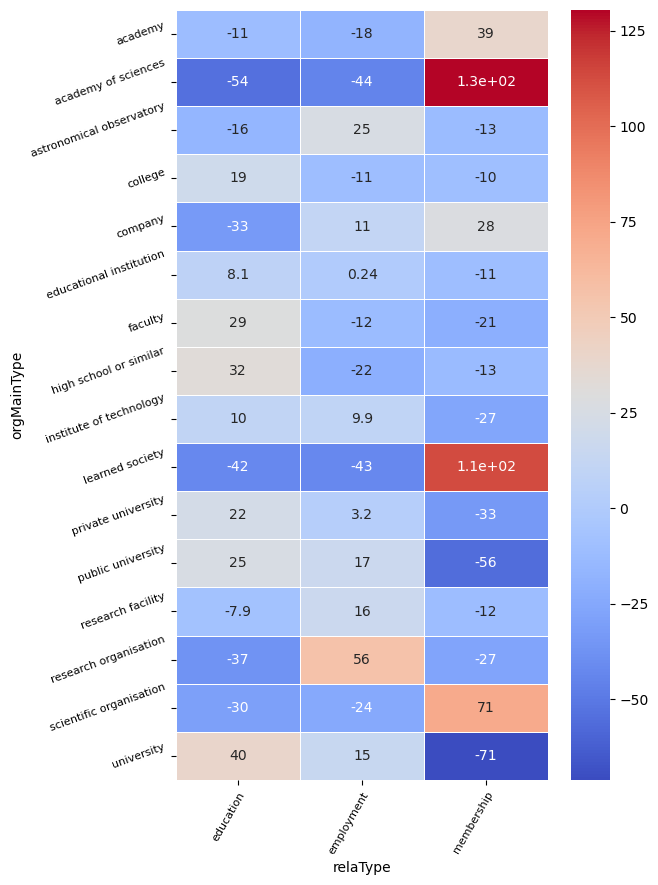

In [103]:
pp = plot_chi2_residuals(ct_wm, figsize=(6, 10))

### Explore contingency table of relationships to organisations : periods, types of organisations

In [104]:


### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1800,1801-1850,1851-1900,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
orgMainType,,,,,,,,,
academy,53,91,117,75,276,301,74,15,1002
academy of sciences,652,985,1429,1277,2141,1349,332,47,8212
astronomical observatory,18,60,169,120,129,165,90,42,793
college,92,108,174,99,167,161,87,23,911
company,111,190,655,603,957,921,566,147,4150
educational institution,15,88,324,268,293,217,97,36,1338
faculty,12,61,300,300,584,513,263,63,2096
high school or similar,61,159,318,333,553,429,244,63,2160
institute of technology,9,94,352,369,734,903,584,128,3173


In [106]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [107]:
### We observe a strong relationship between these two variables
# which is explained by the fact that not all organisations types
# are concerned by the same relationship types
bivariee_stats(ct_wm)

Chi2 : 7837.6 , dof : 105
p-value : 0.0
phi2 = inertie (variance totale) : 0.10019437389326133
Cramer:  0.11963896516081882


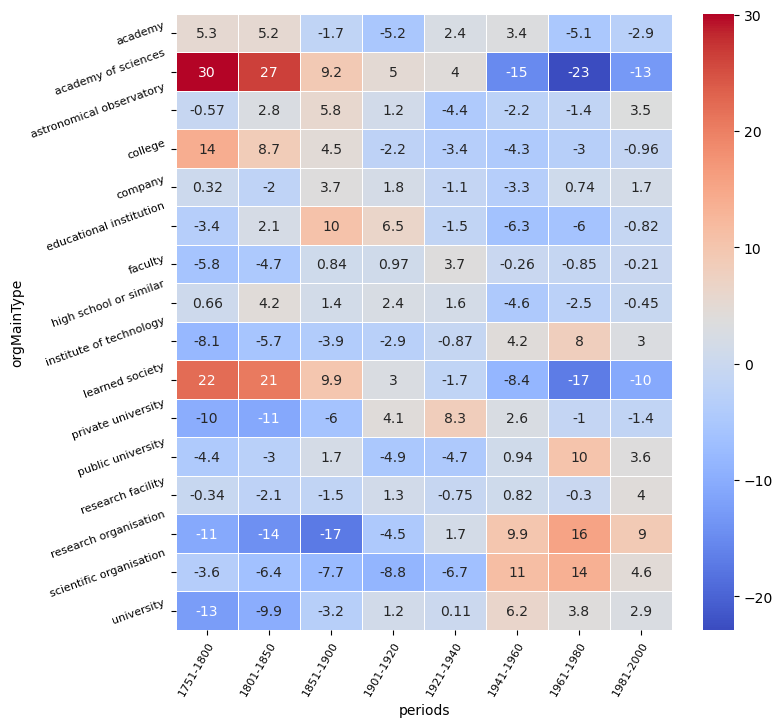

In [110]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [113]:


### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1800,1801-1850,1851-1900,1901-1920,1921-1940,1941-1960,1961-1980,1981-2000,Total
relaType,,,,,,,,,
education,464,1230,3908,4018,7231,7420,4054,969,29294
employment,460,1115,3826,4176,7300,8377,5019,1264,31537
membership,1106,1782,2934,2391,4157,3571,1271,181,17393
Total,2030,4127,10668,10585,18688,19368,10344,2414,78224


In [112]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [114]:
### We observe a strong relationship between these two variables
# which is explained by the fact that not all organisations types
# are concerned by the same relationship types
bivariee_stats(ct_wm)

Chi2 : 3626.88 , dof : 14
p-value : 0.0
phi2 = inertie (variance totale) : 0.046365352705067295
Cramer:  0.1522585838385923


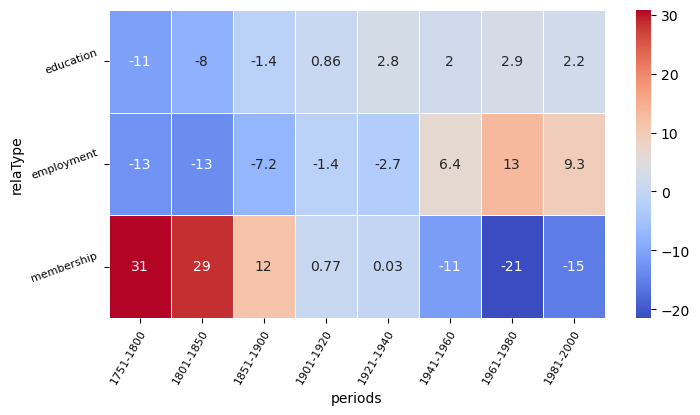

In [116]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [167]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


421652


In [168]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [169]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

166664
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'orgMainType_y', 'relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,orgMainType_y,relaType_y
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,membership,1941-1960,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,university,education
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership
274,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q714717,Christ's College,university,education
275,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society,membership


In [162]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


In [170]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
8,membership,membership,25403
4,employment,employment,24786
1,education,employment,20323
3,employment,education,19878
5,employment,membership,19392
2,education,membership,16206
7,membership,employment,14150
0,education,education,13720
6,membership,education,12806


### Swap values in order to have the same orientation for all relationships

In [183]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [171]:
condition = merged.relaType_x > merged.relaType_y

In [172]:
### Transpose under condition

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [184]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,orgMainType_y,relaType_y
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,university,education,1941-1960,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,membership
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership
274,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q714717,Christ's College,university,education,1941-1960,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment
275,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q466113,American Physical Society,learned society,membership
276,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,membership
277,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q217365,Bell Labs,research organisation,employment
278,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q40358,American Association for the Advancement of Sc...,company,membership


In [ ]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
1,education,employment,40201
4,employment,membership,33542
2,education,membership,29012
5,membership,membership,25403
3,employment,employment,24786
0,education,education,13720


In [ ]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,orgMainType_y,relaType_y,relaType_concat
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,university,education,1941-1960,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,membership,education_membership


In [189]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'uriOrg_y', 'labelOrg_y', 'orgMainType_y', 'relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,orgMainType_x,relaType_x,periods,uriOrg_y,labelOrg_y,orgMainType_y,relaType_y,relaType_concat
269,http://www.wikidata.org/entity/Q100216,Willi Kalender,1949,http://www.wikidata.org/entity/Q838330,University of Wisconsin–Madison,university,education,1941-1960,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,membership,education_membership
273,http://www.wikidata.org/entity/Q1002250,Duncan Haldane,1951,http://www.wikidata.org/entity/Q1536754,Institut Laue–Langevin,company,employment,1941-1960,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,employment_membership


In [200]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [202]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


117949


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
72936,1921-1940,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Michael Rossmann|Sidney Altman|Ludvig Faddeev|...,http://www.wikidata.org/entity/Q101728|http://...,268
99185,1941-1960,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Duncan Haldane|Joseph Incandela|John C. Mather...,http://www.wikidata.org/entity/Q1002250|http:/...,194
47401,1901-1920,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Andrew Huxley|Vitaly Ginzburg|Egon Orowan|Char...,http://www.wikidata.org/entity/Q104607|http://...,186
28747,1851-1900,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Jacobus Henricus van 't Hoff|Peter Debye|Henry...,http://www.wikidata.org/entity/Q102822|http://...,121
72764,1921-1940,membership_membership,http://www.wikidata.org/entity/Q2370801,Academy of Sciences of the USSR,academy of sciences,http://www.wikidata.org/entity/Q83172,Russian Academy of Sciences,academy of sciences,Ludvig Faddeev|Yuri Oganessian|David Pines|Spa...,http://www.wikidata.org/entity/Q1030228|http:/...,109


### A faire: 

* comptage général

* affichage récursif (for: plot ) des valeurs de intermédiarité, effectifs et pouvoir

et en sus les régions géogr. ou les types en couleur

## REprendre et modifier

In [ ]:
### Number of relationships by period, filtered by relaType
print(merged[merged.relaType=='employment'].groupby('periods').size())

### Prepare the data

#### Choice conditions

In [ ]:
p = '1901-1920'
rt = 'membership'
m_p = merged[(merged.periods==p)&(merged.relaType==rt)]
m_p.head(2)

In [ ]:
### Restrict to the considered period

df_op = df_orgPeriod[(df_orgPeriod.periods==p)&(df_orgPeriod.relaType==rt)]
print(len(df_op))
df_op.head(3)

### Merge as self-join

In [ ]:
gr_mer = m_p.groupby(['uriOrg_x', 'uriOrg_y'], as_index = False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})
gr_mer['number'] = gr_mer.labelPer.apply(lambda x : len(x.split('|')))
print(len(gr_mer))
gr_mer.head(2)

In [ ]:
### Join organisations data
gr_mer = gr_mer.merge(df_op, left_on='uriOrg_x', 
                      right_on='uriOrg', how='left', suffixes=('', '_x'))
gr_mer.head(2)

In [ ]:
gr_mer = gr_mer.merge(df_op, left_on='uriOrg_y', 
                      right_on='uriOrg', how='left', suffixes=('_a', '_b'))
gr_mer.head(2)

In [ ]:
gr_mer.sort_values('number', ascending=False).iloc[:10]

In [ ]:
### Normalization attempt
# Exclude institution with just one member
gr_mer['weight'] = gr_mer.apply(lambda x: x.number*2/(x.members_a+x.members_b), axis=1)
gr_mer=gr_mer[(gr_mer.members_a>0)&(gr_mer.members_b>0)]
print(len(gr_mer))
gr_mer.sort_values('weight',ascending=False).iloc[10:17]

### Prepare the graph

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      'weight':e['weight'], 'persNumber':e['number']}
     )) 
     for e in gr_mer.to_dict(orient='records')]
print(len(l))

In [ ]:
## Créate the empty graph
orgG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
orgG.add_edges_from(l)

naf.basic_graph_properties(orgG)


#### Add metadata to nodes

In [ ]:
pprint.pprint(list(orgG.nodes.data())[:3])

In [ ]:
df_orgPeriod.head()

In [ ]:
### Cf. ci-dessus
df_op.head(2)


In [ ]:
df_opl = df_op[['uriOrg', 'labelOrg', 'orgMainType', 'members']].drop_duplicates()
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(orgG, ln)
pprint.pprint(list(orgG.nodes.data())[:2])


#### Components

In [ ]:
### Create a list of graphs, one per component
orgS = [orgG.subgraph(c).copy() for c in nx.connected_components(orgG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(orgS)], key = lambda row: row[1], reverse=True)
print(ln[:5])

### Again we observe that there is a big connected graphe 
# and a multitude of small graphs

#### Analyse components

In [ ]:
### 
li = [0] 
ll = [list(orgS[i[0]].nodes.data()) for i in ln if i[0] in li ]
            
pprint.pprint(sorted(ll[0],
                     key=lambda d: d[1]['membersNumber'], reverse=True)
                     [:5])

In [ ]:
li = li
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, orgS[i])
naf.basic_graph_properties(pG)

In [ ]:
### Alternative way with just one graph
pG = orgS[0]
naf.basic_graph_properties(pG)

In [ ]:
naf.describe_violinplot(edgNumDistr, 'Weight Distribution Density')

In [ ]:
edges_list = [(e[0], e[1]) for e in pG.edges.data() if e[2]['weight'] > 0.09]
# print(edges_list[:2])
sub_pG = pG.edge_subgraph(edges_list).copy()
naf.basic_graph_properties(sub_pG)

In [ ]:
### Create a list of graphs, one per component
sub_S = [sub_pG.subgraph(c).copy() for c in nx.connected_components(sub_pG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(sub_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

### Again we observe that there is a big connected graphe 
# and a multitude of small graphs

In [ ]:
sub_sub_pG = sub_S[0]

In [ ]:
print(np.log(np.sqrt(nx.number_of_nodes(sub_sub_pG))))

In [ ]:
print(np.log(nx.number_of_nodes(sub_sub_pG)))

In [ ]:
pict_addr = 'images/organisations/test_'+ rt + '_' + p +'.svg'
print(pict_addr)

In [ ]:
### Plot the graph

g = sub_sub_pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
node_color = [d[1]*100 for d in nx.degree(g)]
edge_size = [e[2]['persNumber'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["persNumber"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])
"""edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]
"""

nx.draw_networkx_nodes(g, pos, node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = 'images/organisations/base_'+ rt + '_' + p +'.svg'
plt.savefig(pict_addr)
#plt.show()
plt.close()


In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(sub_sub_pG, weight='persNumber')
nx.set_node_attributes(sub_sub_pG, betweenness, 'betweenness')


In [ ]:
### Add eigenvector to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

eigenvector = nx.eigenvector_centrality(sub_sub_pG, weight='persNumber', max_iter=200)
nx.set_node_attributes(sub_sub_pG, eigenvector, 'eigenvector')


In [ ]:
### Add degree to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

degree = dict(nx.degree(sub_sub_pG))
nx.set_node_attributes(sub_sub_pG, degree, 'degree')


In [ ]:
pprint.pprint(list(sub_sub_pG.nodes.data())[:3][:2])

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: sub_sub_pG.nodes[node] for node in sub_sub_pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
#nodes_df.columns = ['orgUri', 'label', 'membersNumber','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
nodes_df.sort_values(by='membersNumber', ascending=False).iloc[:10]

In [ ]:
l_communities = list(nx.community.louvain_communities(sub_sub_pG, resolution=0.5))
print( len(l_communities), l_communities)


In [ ]:
css_colors = [
    "#FF0000",  # Red
    "#0000FF",  # Blue
    "#00FF00",  # Green
    "#FFFF00",  # Yellow
    "#FFA500",  # Orange
    "#964B00",  # Brown
    "#000000",  # Black
    "#C0C0C0",  # Silver
    "#32CD32",  # Lime
    "#03055B",  # Navy
    "#800000",  # Maroon
    "#00FFFF"   # Cyan
]
print(len(css_colors))

In [ ]:
# Create a dictionary to map community IDs to colors
colors = css_colors
color_map = {i: colors[i % len(colors)] for i in range(len(l_communities))}

# Create a dictionary to map nodes to community IDs
node_colors = {}
for i, community in enumerate(l_communities):
    for node in community:
        node_colors[node] = color_map[i]

In [ ]:
print(list(node_colors.items())[:3])

In [ ]:
### Plot the graph

g = sub_sub_pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
node_color = [e[1] for e in list(node_colors.items())]
edge_size = [e[2]['persNumber'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["persNumber"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])
"""edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]
"""

nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_color, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = 'images/organisations/communities_'+ rt + '_' + p +'.svg'
plt.savefig(pict_addr)
#plt.show()
plt.close()


In [ ]:
### Create a list of graphs, one per component
## Connected components
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
try:
    commS = [sub_sub_pG.subgraph(list(c)).copy() for c in l_communities]

    print(len(commS))

    ### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
    ln = sorted([[i,len(g.nodes)] for i,g in enumerate(commS)], key = lambda row: row[1], reverse=True)
    print(ln[:5])


except Exception as e:
    print(e)


In [ ]:

print( len(l_communities), l_communities)
i = 0
list_comm=[(len(c), c) for c in l_communities]
print(list_comm)

In [ ]:
s_ln = pd.Series([e[0] for e in list_comm])
print(s_ln.describe()) 

### Distribution of number of nodes
print('\n\
Distribution of number of nodes:')
l = [print('Nodes in graph: ', e[0],
           ', number of graphs: ', e[1]) for e in s_ln.groupby(by=s_ln).size().items()]



In [ ]:
print(ln[:6])
li = [n[0] for n in ln[:6]]
print(li)

In [ ]:
li = li
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, commS[i])
naf.basic_graph_properties(pG)

In [ ]:
shorted_css_colors = [
    "#FF0000",  # Red
    "#0000FF",  # Blue
    "#00FF00",  # Green
    "#FFFF00",  # Yellow
    "#FFA500",  # Orange
    "#800000",  # Maroon
]
print(len(shorted_css_colors))

In [ ]:
# Create a dictionary to map community IDs to colors
colors = shorted_css_colors
color_map = {i: colors[i % len(colors)] for i in range(len(li))}

# Create a dictionary to map nodes to community IDs
node_colors = {}
for i, community in enumerate(l_communities):
    for node in community:
        node_colors[node] = color_map[i]

In [ ]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*20

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/30 #2.5



### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_color = [e[1] for e in list(node_colors.items())]
edge_size = [e[2]['persNumber'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["persNumber"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])
"""edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]
"""

nx.draw_networkx_nodes(g, pos, node_size=node_size,  alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = 'images/organisations/communities_split_'+ rt + '_' + p +'.svg'
plt.savefig(pict_addr)
#plt.show()
plt.close()


In [ ]:
### Print network


node_colors= [e[1] for e in list(node_colors.items())]
node_size= [n[1]['capital']/70 for n in projSG.nodes.data()]
node_labels=dict([(n[0], ('-'.join((n[1]['label']).split(' ')[:5]) )) for n in projSG.nodes.data()])

edges_width=[e[2]['weight']*100 for e in projSG.edges.data()]

plt.figure(figsize = (12,12))

pos = nx.kamada_kawai_layout(projSG)

k=0.4
#pos=nx.spring_layout(projSG, k=k)

## , cmap=plt.get_cmap('Dark2')
nx.draw_networkx_nodes(projSG, pos, node_size=node_size, node_color=node_colors, alpha=0.4)
nx.draw_networkx_labels(projSG, pos, labels=node_labels, font_size=5)

## no need to draw edges to see the structure of the graph
nx.draw_networkx_edges(projSG, pos,  width=edges_width, alpha=0.2)

plt.title('Clustered Companies (size proportional to capital, color: communities)')

### cf. SVG picture
plt.savefig('images/communitites_companies_scotland.svg')
plt.close()